In [1]:
!pip install -q langchain_openai langgraph langgraph-checkpoint-sqlite tavily-python

In [2]:
from dotenv import load_dotenv

_ = load_dotenv()

In [3]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

conn = sqlite3.connect(":memory:", check_same_thread=False)
memory = SqliteSaver(conn)

In [4]:
import os
from tavily import TavilyClient

tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [5]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int = 1
    max_revisions: int

In [6]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o", temperature=0)

In [7]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}"""

REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""

RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


In [8]:
from pydantic import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [9]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [10]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state.get('content', [])
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [11]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }


In [12]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [13]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state.get('content', [])
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [14]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [15]:
builder = StateGraph(AgentState)

In [16]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [17]:
builder.set_entry_point("planner")

builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)


In [18]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [19]:
graph = builder.compile(checkpointer=memory)

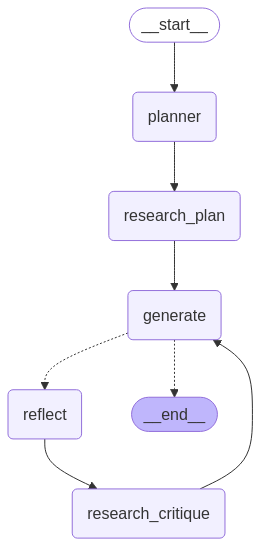

In [20]:
from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        ),
    )
)


In [21]:
thread = {"configurable": {"thread_id": "1"}}

result = []

for s in graph.stream({
    'task': "what is the difference between langchain and langsmith",
    "max_revisions": 2,
}, thread):
    result.append(s)
    

In [22]:
from pprint import pprint

for r in result:
    pprint(r)

{'planner': {'plan': '**Title: Understanding the Differences Between LangChain '
                     'and LangSmith**\n'
                     '\n'
                     '**I. Introduction**\n'
                     '   - Brief introduction to the importance of language '
                     'models and tools in modern technology.\n'
                     '   - Explanation of the purpose of the essay: to '
                     'differentiate between LangChain and LangSmith.\n'
                     '   - Overview of the structure of the essay.\n'
                     '\n'
                     '**II. Background Information**\n'
                     '   - A. Definition and Purpose of Language Models\n'
                     '     - Explanation of what language models are and their '
                     'role in technology.\n'
                     '     - Importance of language models in AI and machine '
                     'learning.\n'
                     '   - B. Introduction to LangCha